# 데이터 가져오기

In [ ]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency
from google.colab import data_table
from collections import Counter
import geopandas as gpd
from shapely.geometry import Point
from geopandas import points_from_xy
from scipy.stats import pearsonr
import statsmodels.api as sm
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 총 4개의 csv 파일 불러온 후, 하나의 파일로 병합
path = "/content/drive/MyDrive/data/Chicago_Crimes_2001_to_2004.csv"
df1 = pd.read_csv(path, on_bad_lines='skip', low_memory=False)

path = "/content/drive/MyDrive/data/Chicago_Crimes_2005_to_2007.csv"
df2 = pd.read_csv(path, on_bad_lines='skip', low_memory=False)

path = "/content/drive/MyDrive/data/Chicago_Crimes_2008_to_2011.csv"
df3 = pd.read_csv(path, on_bad_lines='skip', low_memory=False)

path = "/content/drive/MyDrive/data/Chicago_Crimes_2012_to_2017.csv"
df4 = pd.read_csv(path, on_bad_lines='skip', low_memory=False)

# 데이터 병합
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [ ]:
# 가지고 있는 칼럼 및 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7941282 entries, 0 to 7941281
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   ID                    int64  
 2   Case Number           object 
 3   Date                  object 
 4   Block                 object 
 5   IUCR                  object 
 6   Primary Type          object 
 7   Description           object 
 8   Location Description  object 
 9   Arrest                bool   
 10  Domestic              bool   
 11  Beat                  int64  
 12  District              float64
 13  Ward                  float64
 14  Community Area        float64
 15  FBI Code              object 
 16  X Coordinate          float64
 17  Y Coordinate          object 
 18  Year                  float64
 19  Updated On            object 
 20  Latitude              object 
 21  Longitude             float64
 22  Location              object 
dtypes: bool

In [ ]:
# 칼럼별 상세 설명
crime_attributes_updated = [
    [1, "Unnamed: 0", "원본 파일에서 자동 생성된 인덱스 열", "정수형 (int64)"],
    [2, "ID", "사건 기록의 고유 식별자", "정수형 (int64)"],
    [3, "Case Number", "시카고 경찰청 사건 번호", "문자형 (object)"],
    [4, "Date", "사건 발생 날짜 및 시간", "문자형 (object)"],
    [5, "Block", "사건이 발생한 주소 (블록 단위)", "문자형 (object)"],
    [6, "IUCR", "일리노이 범죄 코드", "문자형 (object)"],
    [7, "Primary Type", "주요 범죄 유형", "문자형 (object)"],
    [8, "Description", "세부 범죄 유형", "문자형 (object)"],
    [9, "Location Description", "사건 발생 장소 설명", "문자형 (object)"],
    [10, "Arrest", "체포 여부", "불리언형 (bool)"],
    [11, "Domestic", "가정폭력 관련 여부", "불리언형 (bool)"],
    [12, "Beat", "사건 발생 경찰 비트 번호", "정수형 (int64)"],
    [13, "District", "사건 발생 경찰 구역 번호", "실수형 (float64)"],
    [14, "Ward", "시의회 선거구 번호", "실수형 (float64)"],
    [15, "Community Area", "시카고 커뮤니티 지역 번호", "실수형 (float64)"],
    [16, "FBI Code", "FBI 범죄 분류 코드", "문자형 (object)"],
    [17, "X Coordinate", "X 좌표 (Illinois State Plane 기준)", "실수형 (float64)"],
    [18, "Y Coordinate", "Y 좌표 (Illinois State Plane 기준)", "문자형 (object)"],
    [19, "Year", "사건 발생 연도", "실수형 (float64)"],
    [20, "Updated On", "기록이 마지막으로 갱신된 시점", "문자형 (object)"],
    [21, "Latitude", "위도 (일부 조정된 위치)", "문자형 (object)"],
    [22, "Longitude", "경도 (일부 조정된 위치)", "실수형 (float64)"],
    [23, "Location", "위도와 경도가 함께 포함된 문자열 위치 정보", "문자형 ('(위도, 경도)' 형식)"]
]

# 데이터프레임 생성
df_crime_attributes_updated = pd.DataFrame(crime_attributes_updated, columns=["번호", "속성명", "설명", "데이터 유형"])

# Colab에서 시각화
data_table.DataTable(df_crime_attributes_updated, include_index=False)

,번호,속성명,설명,데이터 유형
0,1,Unnamed: 0,원본 파일에서 자동 생성된 인덱스 열,정수형 (int64)
1,2,ID,사건 기록의 고유 식별자,정수형 (int64)
2,3,Case Number,시카고 경찰청 사건 번호,문자형 (object)
3,4,Date,사건 발생 날짜 및 시간,문자형 (object)
4,5,Block,사건이 발생한 주소 (블록 단위),문자형 (object)
5,6,IUCR,일리노이 범죄 코드,문자형 (object)
6,7,Primary Type,주요 범죄 유형,문자형 (object)
7,8,Description,세부 범죄 유형,문자형 (object)
8,9,Location Description,사건 발생 장소 설명,문자형 (object)
9,10,Arrest,체포 여부,불리언형 (bool)


## 시각화 전 데이터 전처리
----
1. 결측치 채우기
2. 중복행 제거
3. 데이터 타입 변환

In [ ]:
# 병합한 데이터의 결측치 확인
  # Case Number, Location Description, District, Ward, Community Area, X Coordinate, Y Coordinate, Latitude, Longitude, Location
  # 총 10개의 칼럼에서 결측치 확인

df.isnull().sum()

,0
Unnamed: 0,0
ID,0
Case Number,7
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,1990
Arrest,0


In [ ]:
# Block(사건이 발생한 주소)을 기반으로 위, 경도 결측치 채우기

# Block, 위도, 경도 조합 중복 제거
unique_coords = df[['Block', 'Latitude', 'Longitude']].dropna().drop_duplicates()

# Block별로 위경도 조합이 몇 개인지 개수 세기
coord_variety = unique_coords.groupby('Block').size().reset_index(name='CoordCount')

# 여러 좌표가 있는 Block만 필터링
multiple_coords = coord_variety[coord_variety['CoordCount'] > 1]

print(f"Block 개수: {df['Block'].nunique():,}")
print(f"여러 좌표를 가진 Block 수: {len(multiple_coords):,}")

# 위경도가 비어있지 않은 행만 필터링
df_nonnull = df[df['Latitude'].notnull() & df['Longitude'].notnull()][['Block', 'Latitude', 'Longitude']]

# 각 Block 내에서 (Latitude, Longitude) 쌍(좌표) 중 최빈값을 저장
block_to_coord = {}

for block, group in df_nonnull.groupby('Block'):
    coords = list(zip(group['Latitude'], group['Longitude']))
    mode_coord = Counter(coords).most_common(1)[0][0]  # 최빈 위경도 튜플
    block_to_coord[block] = mode_coord

# 위경도가 비어있는 행만 필터링
mask_coords = df['Latitude'].isnull() | df['Longitude'].isnull()

# 아까 찾은 Block 기준 최빈값으로 위경도 채우기
df.loc[mask_coords, 'Latitude'] = df.loc[mask_coords, 'Block'].map(lambda b: block_to_coord.get(b, (None, None))[0])
df.loc[mask_coords, 'Longitude'] = df.loc[mask_coords, 'Block'].map(lambda b: block_to_coord.get(b, (None, None))[1])

Block 개수: 58,776
여러 좌표를 가진 Block 수: 53,000


In [ ]:
# 채워진 위경도 값을 기반으로 Location 결측치 채우기

# 위경도는 있는데 Location은 없는 행만 필터링
mask_location_fill = (
    df['Location'].isnull() &
    df['Latitude'].notnull() &
    df['Longitude'].notnull()
)

# 해당 조건을 만족하는 행에 대해 Location 생성
df.loc[mask_location_fill, 'Location'] = df.loc[mask_location_fill].apply(
    lambda row: f"({row['Latitude']}, {row['Longitude']})", axis=1
)

In [ ]:
# 채워진 위경도 값을 기반으로 X, Y좌표 결측치 채우기
  # 위경도와 시카고 시공간 데이터에서 사용하는 X,Y좌표의 EPSG가 다름
  # 위경도를 GeoDataFrame으로 바꾼 후, 좌표계 변환하여 X,Y좌표 추출

# 위경도 결측치 없는 행만 선택
geo_mask = df['Latitude'].notnull() & df['Longitude'].notnull()
df_geo = df.loc[geo_mask, ['Latitude', 'Longitude']].copy()

# 벡터화로 Point 객체 생성(메모리 아끼기)
df_geo['geometry'] = points_from_xy(df_geo['Longitude'], df_geo['Latitude'])

# GeoDataFrame 변환
gdf = gpd.GeoDataFrame(df_geo, geometry='geometry', crs='EPSG:4326')

# 좌표계 변환
gdf_3435 = gdf.to_crs(epsg=3435)

# X / Y 좌표 추출
df.loc[geo_mask, 'X Coordinate'] = gdf_3435.geometry.x
df.loc[geo_mask, 'Y Coordinate'] = gdf_3435.geometry.y

In [ ]:
# 시카고 Ward GeoJson 사용하여 Ward(시의회 선거구 번호) 결측치 채우기

# 시카고 Ward GeoJSON 파일 불러오기
gdf_wards = gpd.read_file("/content/drive/MyDrive/data/chicago-wards.geojson")

# 좌표계 확인 및 설정
if gdf_wards.crs is None:
    gdf_wards.set_crs(epsg=4326, inplace=True)
else:
    gdf_wards = gdf_wards.to_crs(epsg=4326)

# Latitude, Longitude는 있지만 Ward가 비어있는 행만 필터링
df_coords = df.loc[
    df['Latitude'].notnull() & df['Longitude'].notnull() & df['Ward'].isnull(),
    ['Latitude', 'Longitude']
].copy()

# 벡터화로 Point 객체 생성(메모리 아끼기)
geometry = gpd.points_from_xy(df_coords['Longitude'].astype(float), df_coords['Latitude'].astype(float))

# GeoDataFrame 생성
gdf_coords = gpd.GeoDataFrame(df_coords, geometry=geometry, crs='EPSG:4326')

# 공간 조인
joined = gpd.sjoin(gdf_coords, gdf_wards, how='left', predicate='within')

# 'ward' 컬럼명 찾기
ward_col_name = [col for col in joined.columns if 'ward' in col.lower()][0]

# 인덱스 정렬 맞춰서 채우기
df.loc[joined.index, 'Ward'] = joined[ward_col_name].values

In [ ]:
# 시카고 커뮤니티 지역 GeoJSON 사용하여 Community Area(시카고 커뮤니티 지역 번호) 결측치 채우기

# 시카고 커뮤니티 지역 GeoJSON 로드
gdf_community = gpd.read_file("/content/drive/MyDrive/data/chicago-community-areas.geojson")
gdf_community = gdf_community.to_crs(epsg=4326)

# Community Area는 비어있지만 위경도는 있는 데이터만 필터링
df_missing_comm = df.loc[
    df['Community Area'].isnull() &
    df['Latitude'].notnull() &
    df['Longitude'].notnull(),
    ['Latitude', 'Longitude']
].copy()

# 인덱스 보존(join 결과를 원본 df에 제대로 매핑할 수 있도록)
df_missing_comm['orig_index'] = df_missing_comm.index

# 데이터가 너무 많아서 5000개 단위로 나눠 공간 조인
batch_size = 5000
filled_area = []

for i in range(0, len(df_missing_comm), batch_size):
    batch = df_missing_comm.iloc[i:i+batch_size].copy()
    # Point 객체 생성 (벡터화)
    geometry = gpd.points_from_xy(batch['Longitude'].astype(float), batch['Latitude'].astype(float))
    gdf_batch = gpd.GeoDataFrame(batch, geometry=geometry, crs='EPSG:4326')

    joined = gpd.sjoin(gdf_batch, gdf_community, how='left', predicate='within')

    # 'community area' 컬럼명 찾기
    comm_col = [col for col in joined.columns if 'community' in col.lower() or 'area' in col.lower()][0]

    # 결과 저장
    filled_area.append(joined[['orig_index', comm_col]])

# 결과 통합
area_result = pd.concat(filled_area)

# 원본 df에 반영
df.loc[area_result['orig_index'], 'Community Area'] = area_result[comm_col].values

In [ ]:
# 결측치 확인
df.isnull().sum()

# 70만 개의 결측치가 있었던 Ward, Community Area의 경우 결측치가 3000개 미만으로 감소
# 10만 개의 결측치가 있었던 위경도와 X,Y좌표의 경우 결측치가 3000개 미만으로 감소

,0
Unnamed: 0,0
ID,0
Case Number,7
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,1990
Arrest,0


In [ ]:
# 중복행 확인
df[df.duplicated()]   # 1,770,469 rows

# 중복행 제거
df = df.drop_duplicates()

In [ ]:
# 외부 데이터를 사용하여 맵핑했던 Community Area 칼럼이 float64 -> object로 변환됨
df['Community Area'].unique()

array([46.0, 61.0, 22.0, 20.0, 49.0, 29.0, 50.0, 73.0, 8.0, 77.0, 65.0,
       43.0, 59.0, 66.0, 23.0, 62.0, 67.0, 32.0, 70.0, 10.0, 25.0, 19.0,
       44.0, 45.0, 28.0, 68.0, 30.0, 40.0, 11.0, 3.0, 71.0, 42.0, 17.0,
       34.0, 63.0, 37.0, 69.0, 55.0, 35.0, 27.0, 48.0, 24.0, 72.0, 18.0,
       15.0, 12.0, 6.0, 7.0, 52.0, 60.0, 26.0, 58.0, 74.0, 64.0, 5.0, 2.0,
       53.0, 56.0, 21.0, 31.0, 51.0, 4.0, 33.0, 39.0, 38.0, 16.0, 41.0,
       1.0, 75.0, 14.0, 57.0, 36.0, 13.0, 76.0, 47.0, 9.0, 'SOUTH SHORE',
       54.0, 'NORTH LAWNDALE', 'HUMBOLDT PARK', 'AUBURN GRESHAM',
       'GREATER GRAND CROSSING', 'GRAND BOULEVARD', 'ENGLEWOOD',
       'ROSELAND', 'SOUTH LAWNDALE', 'CHATHAM', 'WEST ENGLEWOOD',
       'GAGE PARK', 'NEAR WEST SIDE', 'NEW CITY', 'WEST GARFIELD PARK',
       'BRIGHTON PARK', 'WASHINGTON PARK', 'LINCOLN PARK',
       'EAST GARFIELD PARK', 'LOWER WEST SIDE', nan, 'AUSTIN',
       'CHICAGO LAWN', 'RIVERDALE', 'ASHBURN', 'AVALON PARK',
       'MORGAN PARK', 'NEAR NORTH SI

In [ ]:
# 코드와 지역명이 혼합되어 들어가있는 상황
  # 문제 해결을 위해 코드 / 지역명 분리 후 코드, 이름 기반으로 결측치 채우기

# GeoDataFrame 로드
gdf_comm = gpd.read_file('/content/drive/MyDrive/data/chicago-community-areas.geojson')

# 매핑 딕셔너리 생성
comm_map = dict(zip(gdf_comm['area_numbe'].astype(int), gdf_comm['community'].str.upper()))

# 원본을 복사하지 않고 직접 컬럼 처리 (메모리 절약)
import numpy as np

# 지역명인지 숫자인지 판별하는 함수 정의
def is_float(val):
    try:
        float(val)
        return True
    except:
        return False

# 빈 시리즈 생성
df['Community Area Code'] = np.where(df['Community Area'].apply(is_float), df['Community Area'], np.nan)
df['Community Name'] = np.where(df['Community Area'].apply(lambda x: not is_float(x)), df['Community Area'], np.nan)

# 형 변환 (숫자형은 float → int로 바꾸되, 결측치 NaN 유지)
df['Community Area Code'] = pd.to_numeric(df['Community Area Code'], errors='coerce').astype('Int64')

# 이름 결측치 채우기 (코드 기반)
df['Community Name'] = df['Community Name'].fillna(df['Community Area Code'].map(comm_map))

# 코드 결측치 채우기 (이름 기반)
reverse_map = {v: k for k, v in comm_map.items()}
df['Community Area Code'] = df['Community Area Code'].fillna(df['Community Name'].str.upper().map(reverse_map))

# Community Area Code만 남겨두고, 나머지 칼럼은 드랍
# 불필요한 칼럼 드랍
df.drop(columns=['Community Area', 'Community Name'], inplace=True)

In [ ]:
# 데이터 시각화를 위해 데이터를 최대한 보존해야 한다고 판단
  # 따라서, 남은 결측치에 대해서는 'unknown' 또는 0으로 채움
df.isnull().sum()

,0
Unnamed: 0,0
ID,0
Case Number,4
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,1968
Arrest,0


In [ ]:
# 결측치 채우기
df['Community Area Code'] = df['Community Area Code'].fillna(0)
df['Case Number'] = df['Case Number'].fillna('unknown')
df['Location Description'] = df['Location Description'].fillna('unknown')
df['District'] = df['District'].fillna('unknown')
df['Ward'] = df['Ward'].fillna('unknown')
df['X Coordinate'] = df['X Coordinate'].fillna('unknown')
df['Y Coordinate'] = df['Y Coordinate'].fillna('unknown')
df['Latitude'] = df['Latitude'].fillna('unknown')
df['Longitude'] = df['Longitude'].fillna('unknown')
df['Location'] = df['Location'].fillna('unknown')

In [ ]:
# 'unknown'이 없는 칼럼 중, 데이터 타입 변환이 필요한 칼럼 찾기
  # 부득이하게 결측치를 'unknown'으로 채운 칼럼에 대해서는, 필요한 경우 'unknown'을 제외한 나머지 데이터에 대해서만 타입 변환 예정
df.info()

# Date: Datetime으로 변환
# Year: int로 변환

df['Year'] = df['Year'].astype(int)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

<class 'pandas.core.frame.DataFrame'>
Index: 6170813 entries, 0 to 7941281
Data columns (total 23 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Unnamed: 0            int64 
 1   ID                    int64 
 2   Case Number           object
 3   Date                  object
 4   Block                 object
 5   IUCR                  object
 6   Primary Type          object
 7   Description           object
 8   Location Description  object
 9   Arrest                bool  
 10  Domestic              bool  
 11  Beat                  int64 
 12  District              object
 13  Ward                  object
 14  FBI Code              object
 15  X Coordinate          object
 16  Y Coordinate          object
 17  Year                  int64 
 18  Updated On            object
 19  Latitude              object
 20  Longitude             object
 21  Location              object
 22  Community Area Code   Int64 
dtypes: Int64(1), bool(2), int64(4), objec

In [ ]:
# 'Year' 칼럼에 잘못 들어간 값이 있어서 Date 확인 후 올바르게 대체
df.loc[df['Year'] == 41, 'Year'] = 2001

In [ ]:
# 중간 저장 - 지금까지 만진 df csv 파일로 저장!
df.to_csv("data_250409.csv", index=False)

# 구글 드라이브에 저장하기
from google.colab import drive
drive.mount('/content/drive')

# 저장 경로
df.to_csv("/content/drive/MyDrive/final_pj/data_250409.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/final_pj/data_250409.csv")

# 가설 세우기

## (1) 시간과 범죄의 연관성

### 마약 관련 범죄의 요일별 발생 빈도는 유의미한 차이가 있을 것이다.

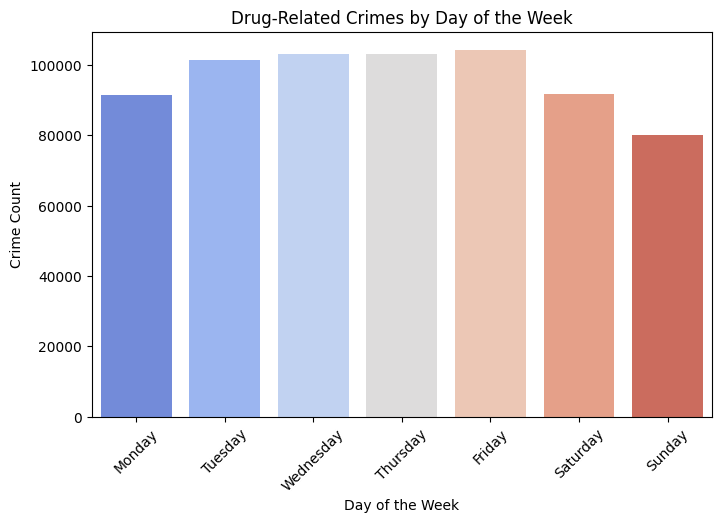

Chi-Square Test Results:
Chi-Square Statistic: 5077.06
p-value: 0.0000


In [ ]:
# 마약 관련 범죄 유형 정의
drug_crime = ['NARCOTICS', 'OTHER NARCOTIC VIOLATION']

# 범죄 유형 필터링
df = df[df['Primary Type'].isin(drug_crime)].copy()

# 요일별 범죄 발생 건수 계산
df['Day of Week'] = df['Date'].dt.day_name()  # 요일 추출

# 요일 순서 지정
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
crime_counts = df['Day of Week'].value_counts().reindex(day_order)

# 요일별 마약 범죄 발생 빈도 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=crime_counts.index, y=crime_counts.values, hue=crime_counts.index, palette="coolwarm")
plt.xlabel("Day of the Week")
plt.ylabel("Crime Count")
plt.title("Drug-Related Crimes by Day of the Week")
plt.xticks(rotation=45)
plt.show()

# 카이제곱 적합도 검정 (요일별 발생 빈도 차이 검정)
observed = np.array(crime_counts)
expected = np.full_like(observed, observed.mean())  # 기대값 = 평균 발생 빈도

# 카이제곱 검정
chi2, p = chisquare(observed, expected)

# 결과 출력
print(f"Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")

In [ ]:
# 요일별 마약 범죄 발생 빈도
observed = np.array(crime_counts)  # 실제 발생 빈도
expected = np.full_like(observed, observed.mean())  # 기대값 = 평균 발생 빈도

# 카이제곱 적합도 검정 수행
chi2, p = chisquare(observed, expected)

# Cramér's V 계산
n = observed.sum()  # 총 사건 수
k = len(observed)   # 요일 개수 (7개: 월~일)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

# 결과 출력
print(f"Cramér's V: {cramers_v:.4f}")

Cramér's V: 0.0354


- 요일별 범죄 발생 빈도 데이터를 비교 (범주형 데이터)

- 카이제곱 검정을 통해 각 범주가 동일하게 분포하는지, 아니면 특정 범주에서 유의미한 차이가 있는지를 분석하기 위해 사용

- 귀무가설(H₀): 요일에 따라 마약 관련 범죄 발생 패턴은 차이가 있다.

- 대립가설(H₁): 요일에 따라 마약 관련 범죄 발생 패턴은 차이가 없다.

- 검정 결과: p-value = 0.0000 (유의수준 0.05보다 작음) → 귀무가설 기각 → 대랍가설 채택  
→ 요일에 따라 마약 관련 범죄 발생 패턴은 차이가 없다 → 마약 범죄 발생은 모든 요일에서 동일한 빈도로 발생.

- Cramér's V = 0.0354 → 요일별 마약범죄 발생 빈도에 차이가 없고, 실질적인 연관성도 거의 없다.

### 범죄 발생 시간대와 범죄 유형은 유의미한 연관성이 있을 것이다.

In [ ]:
df = pd.read_csv("/content/data_250409.csv")

In [ ]:
# 'Date' 컬럼을 datetime 형식으로 변환
df['Date'] = pd.to_datetime(df['Date'])

# 시간대 분류 함수
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# 새로운 컬럼 'Time Period' 추가
df['Time Period'] = df['Date'].dt.hour.apply(categorize_time)

# 시간대별 범죄 유형 분포
crime_by_time = df.groupby('Time Period')['Primary Type'].value_counts().unstack().fillna(0)

# 시간대별 상위 5개 범죄 유형 추출
top_crimes_by_time = {period: crime_by_time.loc[period].sort_values(ascending=False).head(5) for period in ['Morning', 'Afternoon', 'Evening', 'Night']}

# 각 시간대별 상위 5개 범죄 유형 출력
for period in ['Morning', 'Afternoon', 'Evening', 'Night']:
    print(f"{period} 시간대 - Top 5 범죄 유형:")
    print(top_crimes_by_time[period])
    print("\n")

Morning 시간대 - Top 5 범죄 유형:
Primary Type
THEFT              288785.0
BATTERY            181973.0
CRIMINAL DAMAGE    120832.0
BURGLARY           114919.0
NARCOTICS          103593.0
Name: Morning, dtype: float64


Afternoon 시간대 - Top 5 범죄 유형:
Primary Type
THEFT              467999.0
BATTERY            328397.0
NARCOTICS          219091.0
CRIMINAL DAMAGE    170684.0
ASSAULT            136842.0
Name: Afternoon, dtype: float64


Evening 시간대 - Top 5 범죄 유형:
Primary Type
BATTERY            371688.0
THEFT              352969.0
NARCOTICS          294089.0
CRIMINAL DAMAGE    257263.0
ASSAULT            118554.0
Name: Evening, dtype: float64


Night 시간대 - Top 5 범죄 유형:
Primary Type
BATTERY                243667.0
THEFT                  174855.0
CRIMINAL DAMAGE        161304.0
NARCOTICS               57783.0
MOTOR VEHICLE THEFT     55653.0
Name: Night, dtype: float64




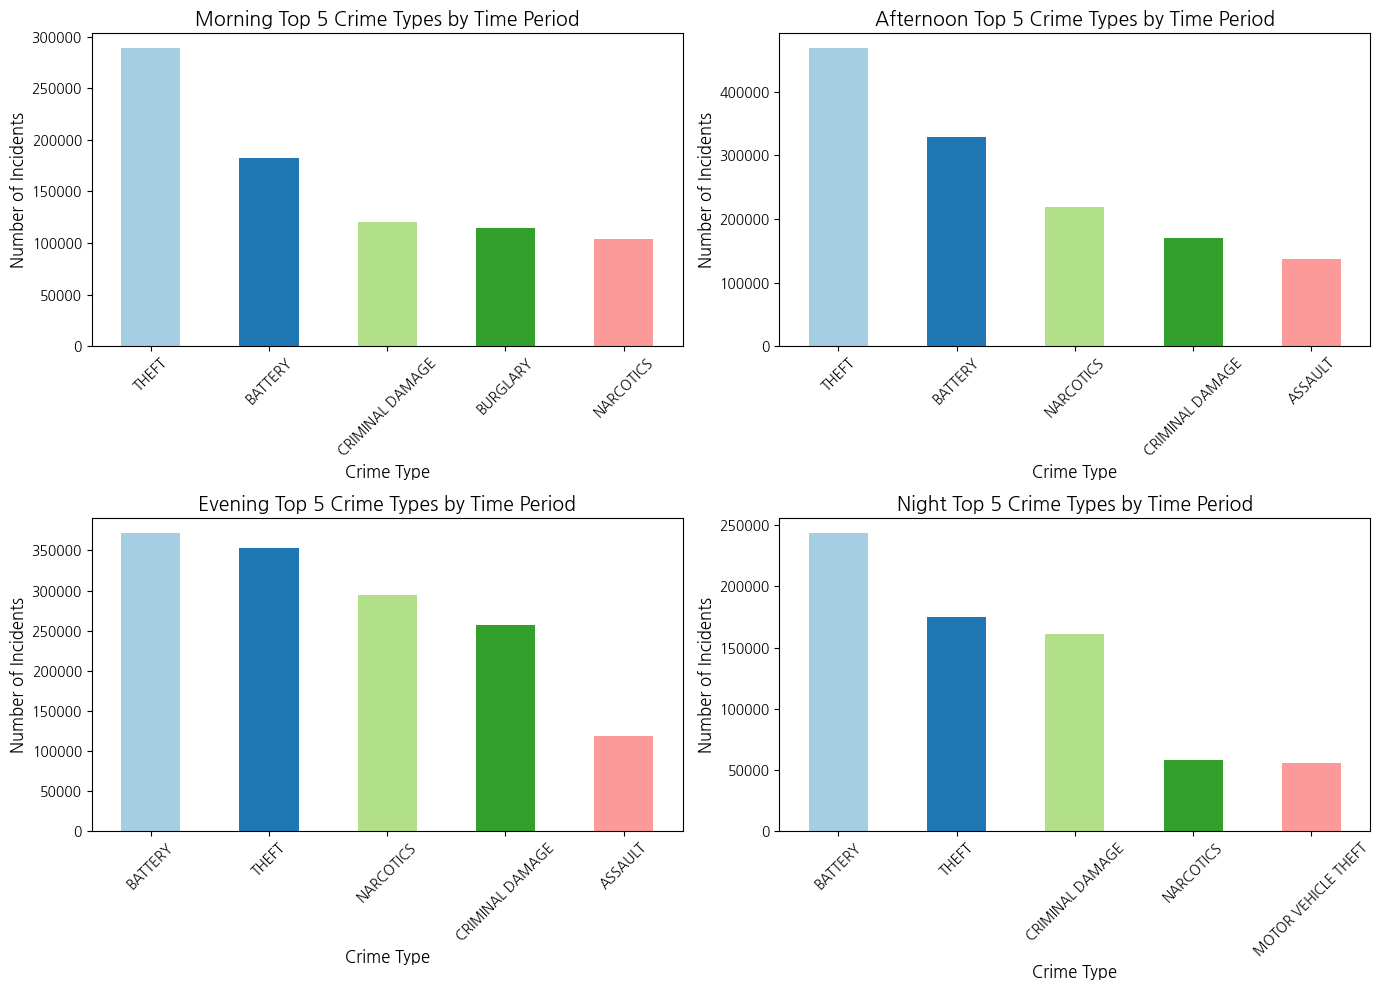

In [ ]:
# 시각화
plt.figure(figsize=(14, 10))

time_periods = ['Morning', 'Afternoon', 'Evening', 'Night']
for i, period in enumerate(time_periods, 1):
    top5_crimes = top_crimes_by_time[period]

    # 서브플롯 생성
    plt.subplot(2, 2, i)
    top5_crimes.plot(kind='bar', stacked=True, color=plt.cm.Paired.colors, figsize=(14, 10))

    plt.title(f"{period} Top 5 Crime Types by Time Period", fontsize=14)
    plt.xlabel('Crime Type', fontsize=12)
    plt.ylabel('Number of Incidents', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def cramers_v(chi2, n, r, c):
    return np.sqrt(chi2 / (n * (min(r, c) - 1))) if min(r, c) > 1 else np.nan

# 시간대별 범죄 유형 분포 테이블
crime_by_time = df.groupby(['Time Period', 'Primary Type']).size().unstack().fillna(0)

# 카이제곱 검정 수행
chi2_stat, p_value, dof, expected = chi2_contingency(crime_by_time)

# 표본 수 (전체 사건 개수)
n = crime_by_time.values.sum()

# 행과 열 개수
r, c = crime_by_time.shape

# Cramér’s V 계산
cramers_v_value = cramers_v(chi2_stat, n, r, c)

# 결과 출력
print("카이제곱 통계량:", chi2_stat)
print("p-value:", p_value)
print("자유도:", dof)
print(f"✅ Cramér’s V: {cramers_v_value:.4f}")

# p-value 해석
if p_value < 0.05:
    print("귀무가설 기각: 시간대별 범죄 유형의 분포에 차이가 있다.")
else:
    print("귀무가설 채택: 시간대별 범죄 유형의 분포에 차이가 없다.")

카이제곱 통계량: 310477.755925622
p-value: 0.0
자유도: 102
✅ Cramér’s V: 0.1295
귀무가설 기각: 시간대별 범죄 유형의 분포에 차이가 있다.


- Cramér's V = 0.1295 → 범죄 발생 시간대에 따라 범죄 유형 분포에 차이는 있으나, 연관성은 약하다.

### 범죄 발생 시간대와 체포율은 유의미한 연관성이 있을 것이다.

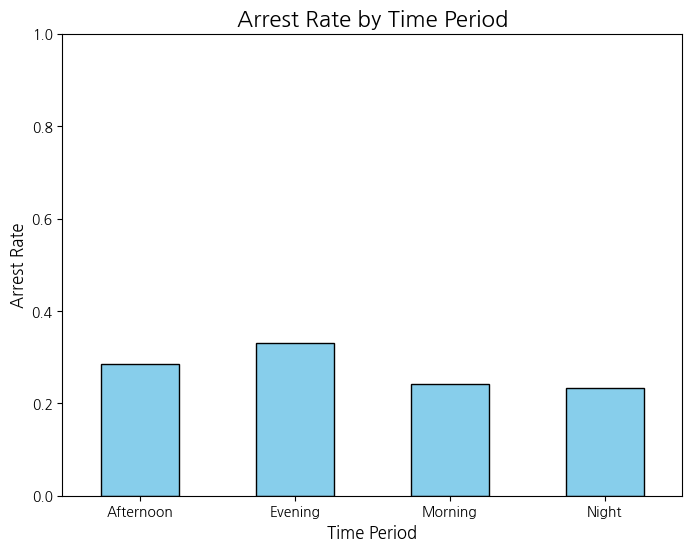

In [ ]:
# 시간대별 체포율 계산
arrest_rate = df.groupby('Time Period')['Arrest'].value_counts(normalize=True).unstack().fillna(0)

# 체포된 비율만 추출 (True 값만 추출)
arrest_rate = arrest_rate[True]

# 시각화 (막대 그래프)
plt.figure(figsize=(8, 6))
arrest_rate.plot(kind='bar', color='skyblue', edgecolor='black')

# 그래프 제목 및 레이블 설정
plt.title('Arrest Rate by Time Period', fontsize=16)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Arrest Rate', fontsize=12)
plt.xticks(rotation=0)  # X축 레이블 회전 없애기
plt.ylim(0, 1)  # 체포율은 0과 1 사이로 설정

# 그래프 출력
plt.show()

In [ ]:
# 시간대별 체포 여부 분포 계산
arrest_by_time = pd.crosstab(df['Time Period'], df['Arrest'])

# 카이제곱 검정 수행
chi2_stat, p_value, dof, expected = chi2_contingency(arrest_by_time)

# Cramér’s V 계산
n = arrest_by_time.sum().sum()  # 전체 샘플 수
r, c = arrest_by_time.shape  # 행, 열 개수
cramers_v = np.sqrt(chi2_stat / (n * (min(r, c) - 1)))

# 결과 출력
print("카이제곱 통계량:", chi2_stat)
print("p-value:", p_value)
print("자유도:", dof)
print(f"✅ Cramér’s V: {cramers_v:.4f}")

# p-value 해석
if p_value < 0.05:
    print("귀무가설 기각: 시간대별 체포율에 차이가 있다.")
else:
    print("귀무가설 채택: 시간대별 체포율에 차이가 없다.")

카이제곱 통계량: 44542.37149486841
p-value: 0.0
자유도: 3
✅ Cramér’s V: 0.0850
귀무가설 기각: 시간대별 체포율에 차이가 있다.


- Cramér's V = 0.0850 → 범죄 발생 시간대에 따라 포율에 차이는 있으나, 연관성은 약하다.

## (2) 공간과 범죄의 연관성

### 마약 관련 범죄는 '주거지' 유형의 장소에서 유의미하게 많이 발생할 것이다.

In [ ]:
# Location Description의 경우 값이 너무 많음 -> 적당한 분류가 필요함

# Residential(거주지) / Commercial(상업 공간) / Public/Institutional(공공 시설)
# Transportation(교통수단 관련) / Outdoor/Open(오픈된 외부) / Other(기타)
# 맵핑해서 새 칼럼 만들기

# 171개의 Location Description을 분류하는 전체 매핑 딕셔너리
category_mapping = {
    # Residential
    'RESIDENCE': 'Residential', 'RESIDENCE PORCH/HALLWAY': 'Residential', 'APARTMENT': 'Residential',
    'HOUSE': 'Residential', 'COACH HOUSE': 'Residential', 'PORCH': 'Residential',
    'GARAGE': 'Residential', 'YARD': 'Residential', 'HALLWAY': 'Residential',
    'RESIDENCE-GARAGE': 'Residential', 'DRIVEWAY - RESIDENTIAL': 'Residential',
    'BASEMENT': 'Residential', 'STAIRWELL': 'Residential', 'ROOMING HOUSE': 'Residential',
    'RESIDENTIAL YARD (FRONT/BACK)': 'Residential', 'CHA APARTMENT': 'Residential',
    'CHA PLAY LOT': 'Residential', 'CHA HALLWAY': 'Residential', 'CHA HALLWAY/STAIRWELL/ELEVATOR': 'Residential',
    'CHA LOBBY': 'Residential', 'CHA STAIRWELL': 'Residential', 'CHA BREEZEWAY': 'Residential',
    'CHA PARKING LOT': 'Residential', 'CHA PARKING LOT/GROUNDS': 'Residential',
    'CHA GROUNDS': 'Residential', 'CHA ELEVATOR': 'Residential',

    # Commercial
    'RETAIL STORE': 'Commercial', 'SMALL RETAIL STORE': 'Commercial', 'DEPARTMENT STORE': 'Commercial',
    'RESTAURANT': 'Commercial', 'TAVERN': 'Commercial', 'LIQUOR STORE': 'Commercial',
    'TAVERN/LIQUOR STORE': 'Commercial', 'BANK': 'Commercial', 'SAVINGS AND LOAN': 'Commercial',
    'DRUG STORE': 'Commercial', 'GROCERY FOOD STORE': 'Commercial', 'CONVENIENCE STORE': 'Commercial',
    'GAS STATION': 'Commercial', 'GAS STATION DRIVE/PROP.': 'Commercial', 'AUTO': 'Commercial',
    'APPLIANCE STORE': 'Commercial',
    'MOVIE HOUSE/THEATER': 'Commercial', 'BOWLING ALLEY': 'Commercial', 'PAWN SHOP': 'Commercial',
    'CLEANING STORE': 'Commercial', 'COIN OPERATED MACHINE': 'Commercial',
    'NEWSSTAND': 'Commercial', 'POOL ROOM': 'Commercial', 'POOLROOM': 'Commercial',
    'CLEANERS/LAUNDROMAT': 'Commercial', 'GARAGE/AUTO REPAIR': 'Commercial',
    'BAR OR TAVERN': 'Commercial', 'BARBER SHOP/BEAUTY SALON': 'Commercial', 'BARBERSHOP': 'Commercial',
    'HAIR SALON': 'Commercial', 'CURRENCY EXCHANGE': 'Commercial', 'CREDIT UNION': 'Commercial',
    'LOBBY': 'Commercial', 'LOADING DOCK': 'Commercial',

    # Public/Institutional
    'SCHOOL, PRIVATE, GROUNDS': 'Public', 'SCHOOL, PUBLIC, BUILDING': 'Public',
    'SCHOOL, PRIVATE, BUILDING': 'Public', 'SCHOOL, PUBLIC, GROUNDS': 'Public',
    'SCHOOL YARD': 'Public', 'PUBLIC GRAMMAR SCHOOL': 'Public', 'PUBLIC HIGH SCHOOL': 'Public',
    'COLLEGE/UNIVERSITY GROUNDS': 'Public', 'COLLEGE/UNIVERSITY RESIDENCE HALL': 'Public',
    'DAY CARE CENTER': 'Public', 'LIBRARY': 'Public', 'HOSPITAL': 'Public',
    'HOSPITAL BUILDING/GROUNDS': 'Public', 'MEDICAL/DENTAL OFFICE': 'Public',
    'NURSING HOME': 'Public', 'NURSING HOME/RETIREMENT HOME': 'Public', 'FUNERAL PARLOR': 'Public',
    'GOVERNMENT BUILDING/PROPERTY': 'Public', 'FEDERAL BUILDING': 'Public',
    'POLICE FACILITY/VEH PARKING LOT': 'Public', 'FIRE STATION': 'Public', 'YMCA': 'Public',
    'CHURCH': 'Public', 'CHURCH PROPERTY': 'Public', 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP': 'Public',
    'OFFICE': 'Public',

    # Transportation
    'PARKING LOT': 'Transportation', 'PARKING LOT/GARAGE(NON.RESID.)': 'Transportation',
    'DRIVEWAY': 'Transportation', 'HIGHWAY/EXPRESSWAY': 'Transportation',
    'VEHICLE NON-COMMERCIAL': 'Transportation', 'VEHICLE-COMMERCIAL': 'Transportation',
    'TAXICAB': 'Transportation', 'TAXI CAB': 'Transportation', 'TRUCKING TERMINAL': 'Transportation',
    'DELIVERY TRUCK': 'Transportation', 'LIVERY STAND OFFICE': 'Transportation',
    'VEHICLE - DELIVERY TRUCK': 'Transportation', 'VEHICLE - OTHER RIDE SERVICE': 'Transportation',
    'TRUCK': 'Transportation', 'DELIVERY TRUCK': 'Transportation',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA': 'Transportation',
    'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA': 'Transportation',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA': 'Transportation',
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA': 'Transportation',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA': 'Transportation',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA': 'Transportation',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA': 'Transportation',
    'AIRPORT EXTERIOR - SECURE AREA': 'Transportation',
    'AIRPORT EXTERIOR - NON-SECURE AREA': 'Transportation',
    'AIRPORT PARKING LOT': 'Transportation',
    'AIRPORT/AIRCRAFT': 'Transportation', 'AIRCRAFT': 'Transportation',
    'AIRPORT VENDING ESTABLISHMENT': 'Transportation', 'AIRPORT TRANSPORTATION SYSTEM (ATS)': 'Transportation',
    'CTA BUS': 'Transportation', 'CTA "L" TRAIN': 'Transportation', 'CTA "L" PLATFORM': 'Transportation',
    'CTA PLATFORM': 'Transportation', 'CTA STATION': 'Transportation',
    'CTA PROPERTY': 'Transportation', 'CTA GARAGE / OTHER PROPERTY': 'Transportation',
    'CTA BUS STOP': 'Transportation', 'CTA TRACKS - RIGHT OF WAY': 'Transportation',

    # Outdoor/Open
    'STREET': 'Outdoor', 'SIDEWALK': 'Outdoor', 'ALLEY': 'Outdoor', 'SEWER': 'Outdoor', 'BRIDGE': 'Outdoor',
    'PARK PROPERTY': 'Outdoor', 'FOREST PRESERVE': 'Outdoor', 'PARK': 'Outdoor',
    'RIVER': 'Outdoor', 'LAKE': 'Outdoor', 'RIVER BANK': 'Outdoor',
    'LAKEFRONT/WATERFRONT/RIVERBANK': 'Outdoor', 'CEMETARY': 'Outdoor',
    'WOODED AREA': 'Outdoor', 'VACANT LOT': 'Outdoor', 'VACANT LOT/LAND': 'Outdoor',
    'PRAIRIE': 'Outdoor', 'JUNK YARD/GARBAGE DUMP': 'Outdoor',

    # Other
    'OTHER': 'Other', 'UNKNOWN': 'Other', 'DUMPSTER': 'Other', 'VESTIBULE': 'Other',
    'CHA ELEVATOR': 'Other', 'FACTORY/MANUFACTURING BUILDING': 'Other', 'FACTORY': 'Other',
    'WAREHOUSE': 'Other', 'LOADING DOCK': 'Other', 'CONSTRUCTION SITE': 'Other',
    'ANIMAL HOSPITAL': 'Other', 'TRAILER': 'Other', 'ATM (AUTOMATIC TELLER MACHINE)': 'Other',
    'ATHLETIC CLUB': 'Other', 'LIVERY AUTO': 'Other', 'ELEVATOR': 'Other', 'NEWSSTAND': 'Other',
    'CLEANERS/LAUNDROMAT': 'Other', 'BOAT/WATERCRAFT': 'Other', 'BANQUET HALL': 'Other',
}

df['Location Category'] = df['Location Description'].map(category_mapping).fillna('Other')

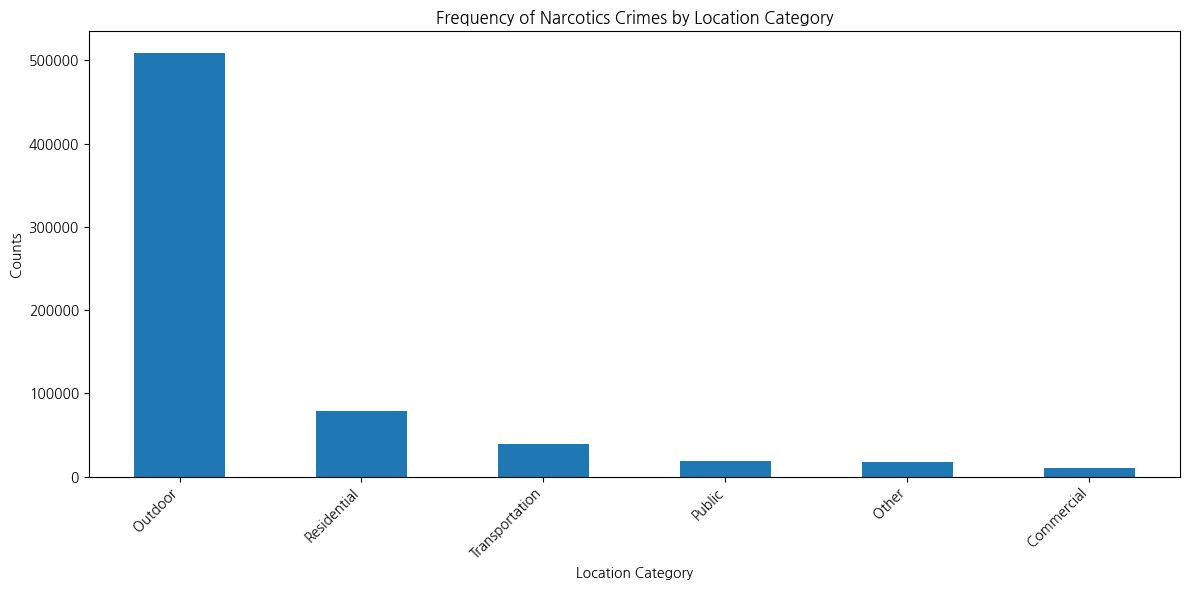

Chi-squared Statistic: 1708594.75, p-value: 0.0000000000


In [ ]:
# 마약 관련 범죄만 필터링
narcotic_types = ['NARCOTICS', 'OTHER NARCOTIC VIOLATION']
df_narcotics = df[df['Primary Type'].isin(narcotic_types)]

# 장소 유형별 빈도
location_counts = df_narcotics['Location Category'].value_counts()

# 그래프로 시각화
location_counts.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))

plt.title('Frequency of Narcotics Crimes by Location Category')
plt.xlabel('Location Category')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 기대값: 균등하게 발생했다고 가정할 경우
expected = [location_counts.sum() / len(location_counts)] * len(location_counts)

# 카이제곱 적합도 검정
chi2_stat, p_value = chisquare(location_counts.values, f_exp=expected)

print(f"Chi-squared Statistic: {chi2_stat:.2f}, p-value: {p_value:.10f}")

- 귀무가설 (H₀):
마약 범죄 내부에서 장소 유형 간 발생 빈도의 차이가 유의미하지 않다.
→ 즉, 마약 범죄가 특정 장소에서 더 자주 발생하지 않는다. 다른 범죄와 비교해 특정 장소에 편중되어 있지 않다.
- 대립가설 (H₁):
마약 범죄 내부에서 장소 유형 간 발생 빈도의 차이가 유의미하다.
→ 즉, 마약 범죄는 특정 장소 유형에서 더 자주 발생한다.
장소와 범죄 유형 간에 통계적으로 유의미한 관련이 있다.
  - p-value < 0.05
  - **귀무가설 기각: 마약 범죄는 특정 장소 유형에서 더 자주 발생한다.
장소와 범죄 유형 간에 통계적으로 유의미한 관련이 있다.**
  - **또한, 데이터 시각화를 통해 주로 Outdoor 카테고리의 장소에서 많이 발생하는 경향성을 확인했다.**
  - 그리고 단일 변수의 분포 분석이기 때문에, Cramér’s V처럼 변수 간 관계의 강도를 측정할 수는 없다.